#### Installing Dependencies

In [2]:
!pip install split-folders

#### Splitting Train & Validation Data

In [3]:
import splitfolders

input_folder = '/kaggle/input/iranis'
output_folder = '/kaggle/working/output'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))

Copying files: 83844 files [08:17, 168.69 files/s]


#### Preprocessing & Resizing Data

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

train_dir = output_folder + '/train'
val_dir = output_folder + '/val'

def custom_preprocessing(image):
    """
    Ensures the final result is:
      - black characters (foreground)
      - white background
    Steps:
      1) Convert to grayscale
      2) Resize to 64x64
      2.5) Apply CLAHE
      3) Gaussian blur
      4) Otsu threshold
      5) Invert if background is black
      6) Morphological opening (treat black chars as 'foreground' by inverting temporarily)
      7) Scale to [0,1]
    """

    # Convert from PIL image to NumPy array
    image_np = np.array(image)

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # 2) Resize to 64x64
    gray_resized = cv2.resize(gray, (64, 64), interpolation=cv2.INTER_AREA)

    # Make sure it's 8-bit if it isn't already
    # If your image might be float in [0..1], convert properly:
    if gray_resized.max() <= 1.0:
        gray_resized = (gray_resized * 255).astype(np.uint8)
    else:
        gray_resized = gray_resized.astype(np.uint8)

    # 2.5) Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_resized)

    # 3) Gaussian blur (e.g. 3x3 kernel)
    blurred = cv2.GaussianBlur(clahe_img, (5, 5), 0)

    # 4) Otsu Threshold
    _, thresh = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )

    # 5) Check if background is black => If so, invert to get black chars on white
    white_pixels = np.count_nonzero(thresh == 255)
    black_pixels = thresh.size - white_pixels
    if black_pixels > white_pixels:
        thresh = cv2.bitwise_not(thresh)  # invert

    # 6) Morphological opening
    #    By default, OpenCV morphological operations treat white as foreground.
    #    Since we want black text as foreground, we invert, open, then invert back.
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    inv = cv2.bitwise_not(thresh)
    opened_inv = cv2.morphologyEx(inv, cv2.MORPH_OPEN, kernel)
    opened = cv2.bitwise_not(opened_inv)

    # 7) Scale to [0,1]
    opened = opened.astype(np.float32) / 255.0

    # Expand dims for grayscale (channels=1)
    opened = np.expand_dims(opened, axis=-1)

    return opened


train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,

)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing
)

# If you're resizing inside custom_preprocessing, you can set target_size to (32, 32) just for consistency.
img_height, img_width = 64, 64
batch_size = 256

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # or (64,64), but (32,32) is more consistent now.
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 67065 images belonging to 28 classes.
Found 16779 images belonging to 28 classes.


#### Visualizing Random Samples

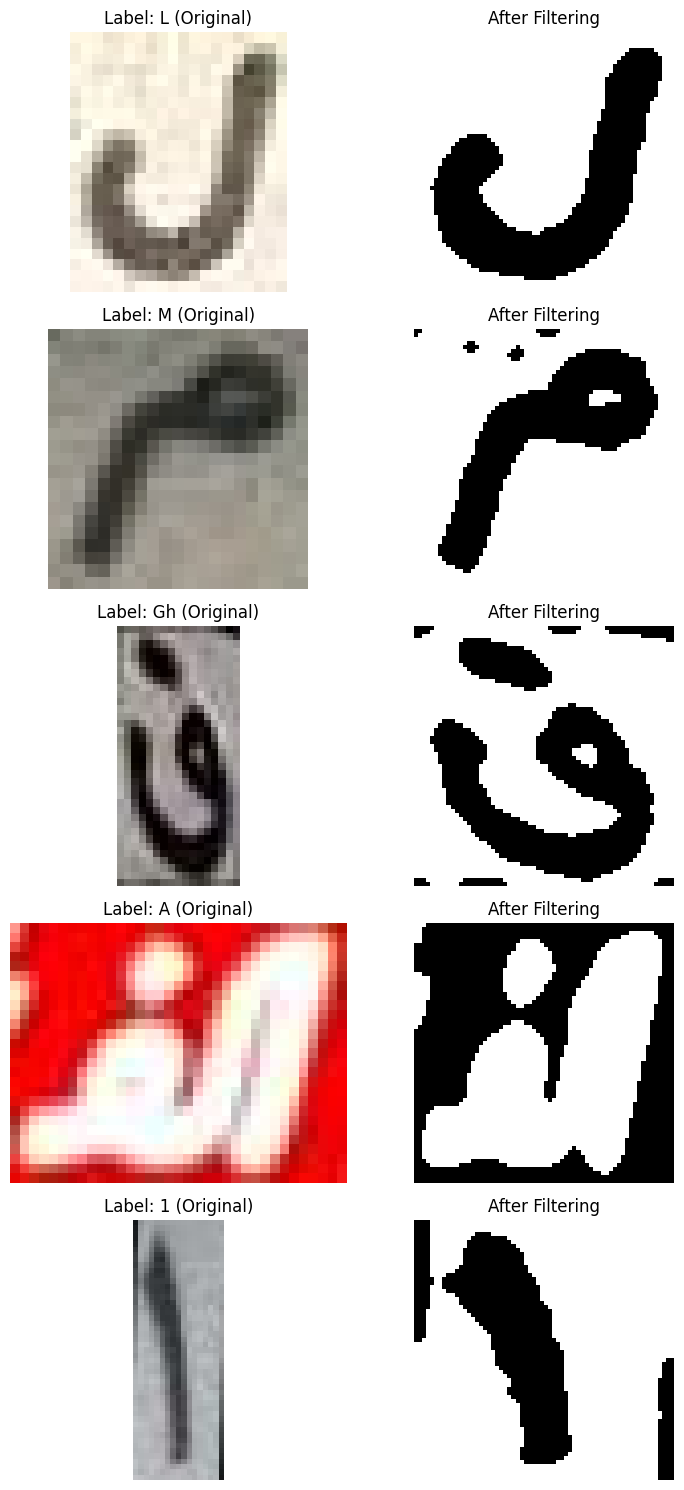

In [5]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def get_random_samples(parent_dir, num_samples=5):
    """
    Returns a list of (image_path, label) pairs, choosing one random
    image from a random set of subfolders.
    """
    all_labels = [d for d in os.listdir(parent_dir) 
                  if os.path.isdir(os.path.join(parent_dir, d))]

    samples = []
    for _ in range(num_samples):
        label = random.choice(all_labels)
        label_dir = os.path.join(parent_dir, label)
        images_in_label = os.listdir(label_dir)
        if not images_in_label:
            continue
        img_name = random.choice(images_in_label)
        img_path = os.path.join(label_dir, img_name)
        samples.append((img_path, label))
    
    return samples

# Let's pick 5 random samples
samples = get_random_samples(train_dir, num_samples=5)

def show_before_after(samples):
    """
    samples: list of (image_path, label) tuples
    """
    fig, axes = plt.subplots(len(samples), 2, figsize=(8, 3 * len(samples)))
    
    for i, (img_path, label) in enumerate(samples):
        # Read with OpenCV (BGR channel order)
        original_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if original_bgr is None:
            print(f"Warning: Could not read {img_path}")
            continue
        
        # Convert BGR -> RGB for display
        original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)

        # Apply filtering
        filtered_bgr = custom_preprocessing(original_bgr)
        filtered_rgb = cv2.cvtColor(filtered_bgr, cv2.COLOR_BGR2RGB)

        # Plot original
        axes[i, 0].imshow(original_rgb)
        axes[i, 0].set_title(f"Label: {label} (Original)")
        axes[i, 0].axis('off')

        # Plot filtered
        axes[i, 1].imshow(filtered_rgb)
        axes[i, 1].set_title("After Filtering")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Finally, display them
show_before_after(samples)


#### Building & Training the CNN Model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assume img_height, img_width, and train_generator are predefined
num_classes = train_generator.num_classes

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu',
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

# Train the model
epochs = 16

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 28)                  │           3,612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,628,764 (6.21 MB)

 Trainable params: 1,628,764 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/16


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


262/262 ━━━━━━━━━━━━━━━━━━━━ 98s 344ms/step - accuracy: 0.6702 - loss: 1.1571 - val_accuracy: 0.9730 - val_loss: 0.1115
Epoch 2/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 322ms/step - accuracy: 0.9407 - loss: 0.1972 - val_accuracy: 0.9826 - val_loss: 0.0683
Epoch 3/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 89s 331ms/step - accuracy: 0.9566 - loss: 0.1418 - val_accuracy: 0.9841 - val_loss: 0.0613
Epoch 4/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 329ms/step - accuracy: 0.9660 - loss: 0.1109 - val_accuracy: 0.9861 - val_loss: 0.0541
Epoch 5/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 323ms/step - accuracy: 0.9696 - loss: 0.0938 - val_accuracy: 0.9868 - val_loss: 0.0520
Epoch 6/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 85s 318ms/step - accuracy: 0.9728 - loss: 0.0835 - val_accuracy: 0.9856 - val_loss: 0.0595
Epoch 7/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 85s 316ms/step - accuracy: 0.9752 - loss: 0.0774 - val_accuracy: 0.9871 - val_loss: 0.0548
Epoch 8/16
262/262 ━━━━━━━━━━━━━━━━━━━━ 86s 321ms/step - accuracy: 0.9783 - loss: 0.0649 - val

#### Plotting Training Accuracy & Loss

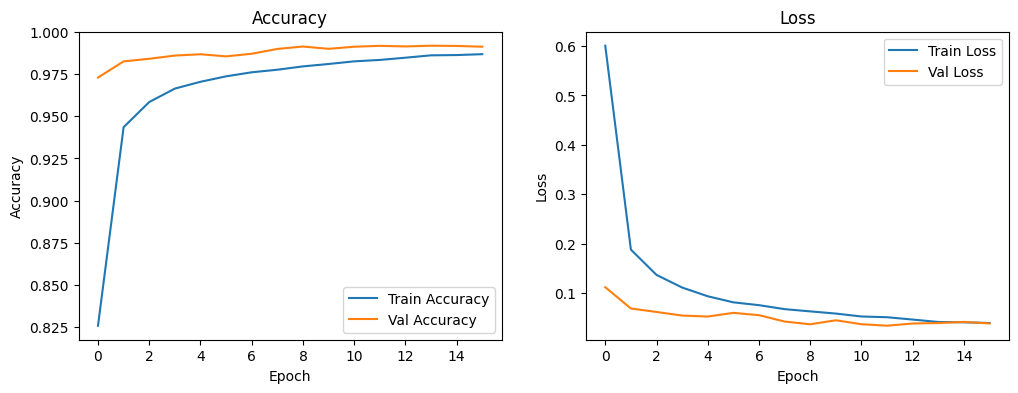

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [8]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9857 - loss: 0.0618
Validation Loss: 0.0381
Validation Accuracy: 0.9913


#### Evaluation & Confusion Matrix

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

# Class labels
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))



66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       501
           1       1.00      0.98      0.99       699
           2       0.98      0.98      0.98       786
           3       0.98      0.96      0.97       549
           4       0.99      0.99      0.99      1155
           5       0.98      0.99      0.99       722
           6       0.98      1.00      0.99      1151
           7       0.99      0.99      0.99       748
           8       0.99      0.99      0.99       717
           9       0.99      0.99      0.99       706
           A       1.00      1.00      1.00       504
           B       0.99      0.99      0.99       503
           D       1.00      0.99      1.00       501
          Gh       1.00      0.99      1.00       497
           H       1.00      1.00      1.00       512
           J       0.99      1.00      1.00       501
           L       0.99      0.98      

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 487    1    0    0    1    4    7    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    1]
 [   0  684    1    1    0    0    1    4    1    1    1    0    0    0
     0    0    0    0    2    0    0    0    0    0    1    0    2    0]
 [   0    0  774    8    2    0    0    2    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    9  529    9    0    1    0    0    0    0    0    0    0
     1    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    2    3 1146    0    2    0    0    1    0    0    0    0
     0    0    0    0    1    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  718    0    0    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    1    0 1146    0    0    0    0    0    0    0
     0    0    0    0    0    0    2    

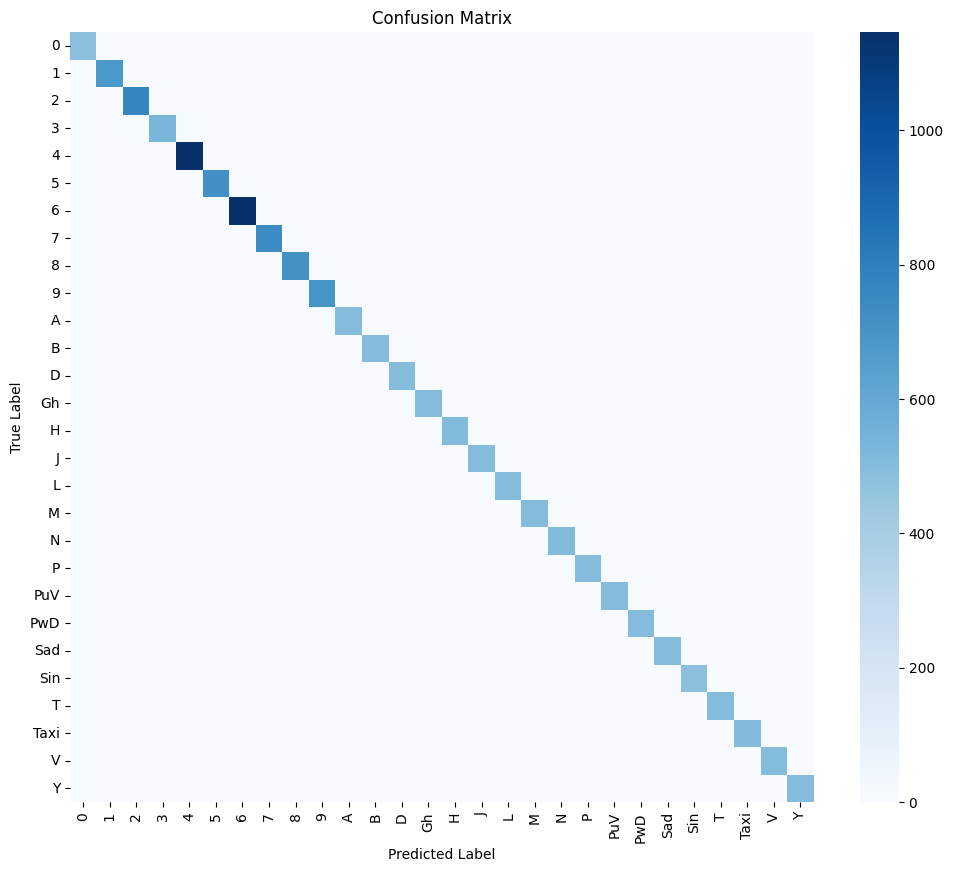

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Suppose you already have these:
# cm = confusion_matrix(y_true, y_pred)
# class_labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(
    cm,                       # Your confusion matrix
    annot=False,             # Set True if you want each cell’s number
    cmap="Blues",            # Color map
    fmt="d",                 # Format for numbers (integers)
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [12]:
!pip install ultralytics

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 18.8 MB/s eta 0:00:0000:01


(-0.5, 599.5, 425.5, -0.5)

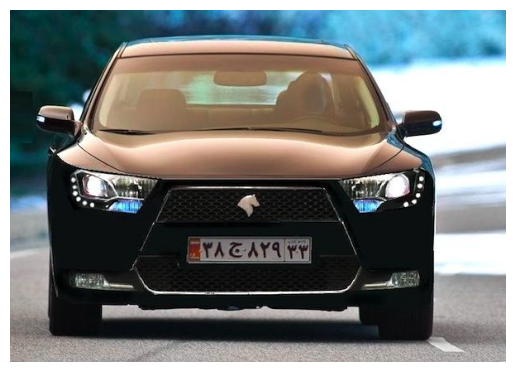

In [126]:
# Read the image
image_path = '/kaggle/input/test-images/Iran-Khodro-Dena.jpg'  # Replace with your image path

frame = cv2.imread(image_path)

plt.imshow(frame)
plt.axis('off')

#### YOLO Plate Detection


0: 576x800 1 Vehicle_registration_plate, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 800)


(-0.5, 132.5, 32.5, -0.5)

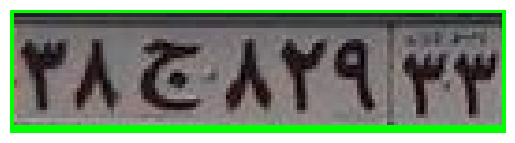

In [15]:
#%% find plate from image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2
import re

model_plate = YOLO('/kaggle/input/yolo-license-plate-and-char-detection/pytorch/default/1/best.pt')  # Replace 'best.pt' with the path to your trained model

# Perform detection
results = model_plate.predict(frame)

# Iterate over detected license plates and draw bounding boxes
for result in results:
    boxes = result.boxes.xyxy  # Bounding box coordinates

    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        # Draw rectangle around the license plate
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cropped_plate = frame[y1:y2+1, x1:x2+1]
        
plt.imshow(cropped_plate)
plt.axis('off')

#### YOLO Character Detection


0: 160x640 1 3, 2 As, 1 P, 4 Ys, 10.0ms
Speed: 0.8ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 160, 640)
Number of cropped images: 8


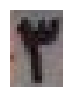

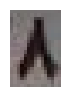

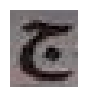

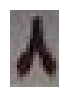

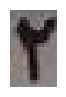

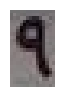

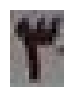

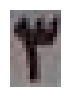

In [19]:
#%% find chars in plate

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model_char = YOLO('/kaggle/input/yolo-license-plate-and-char-detection/pytorch/default/1/best_chars.pt')  # Load your trained model

# Read the image
# Assume 'cropped_plate' is already defined and contains the image data

# Run inference on the image
results = model_char(cropped_plate, conf=0.4, iou=0.7)

# Initialize an array to store cropped images and their x-coordinates
cropped_images = []
x_coordinates = []

# Process the results
for result in results:
    boxes = result.boxes.cpu().numpy()  # Get bounding boxes
    for box in boxes:
        # Get box coordinates
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Crop the image using the bounding box
        cropped_image = cropped_plate[y1:y2, x1:x2]

        # Append the cropped image and its x-coordinate to the arrays
        cropped_images.append(cropped_image)
        x_coordinates.append(x1)  # Store the left x-coordinate

# Combine images and their corresponding x-coordinates into a list of tuples
sorted_images_with_coords = sorted(zip(x_coordinates, cropped_images), key=lambda pair: pair[0])

# Unzip the sorted tuples back into two lists
sorted_x_coordinates, sorted_cropped_images = zip(*sorted_images_with_coords)

# Save or display the sorted cropped images
for i, img in enumerate(sorted_cropped_images):
    # Save each cropped image to a file (optional)
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.axis('off')
    cv2.imwrite(f'cropped_image_{i}.jpg', img)

# Print the number of cropped images
print(f"Number of cropped images: {len(sorted_cropped_images)}")


#### Final Character Classification

In [20]:
# predict chars
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def custom_preprocessing(image):
    """
    Ensures the final result is:
      - black characters (foreground)
      - white background
    Steps:
      1) Convert to grayscale
      2) Resize to 64x64
      2.5) Apply CLAHE
      3) Gaussian blur
      4) Otsu threshold
      5) Invert if background is black
      6) Morphological opening (treat black chars as 'foreground' by inverting temporarily)
      7) Scale to [0,1]
    """

    # Convert from PIL image to NumPy array
    image_np = np.array(image)

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # 2) Resize to 64x64
    gray_resized = cv2.resize(gray, (64, 64), interpolation=cv2.INTER_AREA)

    # Make sure it's 8-bit if it isn't already
    # If your image might be float in [0..1], convert properly:
    if gray_resized.max() <= 1.0:
        gray_resized = (gray_resized * 255).astype(np.uint8)
    else:
        gray_resized = gray_resized.astype(np.uint8)

    # 2.5) Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_resized)

    # 3) Gaussian blur (e.g. 3x3 kernel)
    blurred = cv2.GaussianBlur(clahe_img, (5, 5), 0)

    # 4) Otsu Threshold
    _, thresh = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )

    # 5) Check if background is black => If so, invert to get black chars on white
    white_pixels = np.count_nonzero(thresh == 255)
    black_pixels = thresh.size - white_pixels
    if black_pixels > white_pixels:
        thresh = cv2.bitwise_not(thresh)  # invert

    # 6) Morphological opening
    #    By default, OpenCV morphological operations treat white as foreground.
    #    Since we want black text as foreground, we invert, open, then invert back.
    kernel_size = 3
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    inv = cv2.bitwise_not(thresh)
    opened_inv = cv2.morphologyEx(inv, cv2.MORPH_OPEN, kernel)
    opened = cv2.bitwise_not(opened_inv)

    # 7) Scale to [0,1]
    opened = opened.astype(np.float32) / 255.0

    # Expand dims for grayscale (channels=1)
    opened = np.expand_dims(opened, axis=-1)

    return opened
    
# For demonstration, let's assume your model expects input shape (64, 64, 3).
img_height = 64
img_width  = 64

# 2) Preprocess each cropped image
processed_images = []
for i, img in enumerate(sorted_cropped_images):
    processed_images.append(custom_preprocessing(img))

# Convert to NumPy array for batch prediction
processed_images = np.array(processed_images)  # shape = (N, 64, 64, 3)
processed_images = np.repeat(processed_images, repeats=3, axis=-1)

# 3) Make predictions
predictions = model.predict(processed_images)

# If your model has a softmax final layer for N classes (say letters/digits),
# 'predictions' is shape (N, num_classes). The highest-value index is the predicted class.
predicted_classes = np.argmax(predictions, axis=1)  # shape = (N,)

# 4) If you have a mapping from class index to actual character,
#    e.g. classes = ['0','1','2', ... '9','A','B','C'...], do:
class_names = ['0','1','2','3','4','5','6','7','8','9',
               'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R']  
# Example for 10 digits + 18 letters = 28 classes

for i, class_idx in enumerate(predicted_classes):
    predicted_char = class_names[class_idx]
    confidence = predictions[i][class_idx]  # Probability of predicted class
    print(f"Cropped image {i}: predicted '{predicted_char}' with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Cropped image 0: predicted '3' with confidence 1.00
Cropped image 1: predicted '8' with confidence 1.00
Cropped image 2: predicted 'F' with confidence 1.00
Cropped image 3: predicted '8' with confidence 1.00
Cropped image 4: predicted '2' with confidence 1.00
Cropped image 5: predicted '9' with confidence 1.00
Cropped image 6: predicted '3' with confidence 1.00
Cropped image 7: predicted '3' with confidence 1.00
